In [26]:
!ls

drive  sample_data


In [50]:
import torch
from torch import nn
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import os
%matplotlib inline

In [51]:
# 0. Patch Embedding Variables
p = 16 # patch
w = 224 # width
h = 224 # height
c = 3 # channel
b = 10 # batch

In [7]:
# 0. 이미지 불러오기 (Using Numpy)
# 변환할 이미지 목록 불러오기
image_path = 'drive/MyDrive/Vision-Transformer/dataset/'

img_list = os.listdir(image_path) #디렉토리 내 모든 파일 불러오기
img_list_jpg = [img for img in img_list if img.endswith(".jpeg")] #지정된 확장자만 필터링

print ("img_list_jpg: {}".format(img_list_jpg))

img_list_np = []

for i in img_list_jpg:
    img = Image.open(image_path + i)
    resized_ = img.resize((w,h))
    img_array = np.array(resized_)
    img_list_np.append(img_array)
    print(i, " 추가 완료 - 구조:", img_array.shape) # 불러온 이미지의 차원 확인 (세로X가로X색)
    #print(img_array.T.shape) #축변경 (색X가로X세로)


img_list_jpg: ['001.jpeg', '003.jpeg', '002.jpeg', '004.jpeg', '005.jpeg', '006.jpeg', '007.jpeg', '008.jpeg', '009.jpeg', '010.jpeg']
001.jpeg  추가 완료 - 구조: (224, 224, 3)
003.jpeg  추가 완료 - 구조: (224, 224, 3)
002.jpeg  추가 완료 - 구조: (224, 224, 3)
004.jpeg  추가 완료 - 구조: (224, 224, 3)
005.jpeg  추가 완료 - 구조: (224, 224, 3)
006.jpeg  추가 완료 - 구조: (224, 224, 3)
007.jpeg  추가 완료 - 구조: (224, 224, 3)
008.jpeg  추가 완료 - 구조: (224, 224, 3)
009.jpeg  추가 완료 - 구조: (224, 224, 3)
010.jpeg  추가 완료 - 구조: (224, 224, 3)


In [52]:
# 0. 이미지 불러오기 (Using torchvision)
import torchvision.transforms as transforms

image_path = 'drive/MyDrive/Vision-Transformer/dataset/'

img_list = os.listdir(image_path) #디렉토리 내 모든 파일 불러오기
img_list_jpg = [img for img in img_list if img.endswith(".jpeg")] #지정된 확장자만 필터링

output = []
for i in img_list_jpg:
  PIL_tensor = transforms.ToTensor()
  img = Image.open(image_path + i)
  img = ImageOps.exif_transpose(img) # EXIF로 인해서 이미지가 회전되는 현상을 방지
  resized_ = img.resize((w,h))
  Image_tensor = PIL_tensor(resized_)
  output.append(Image_tensor)
  print(i, "Added", Image_tensor.shape)
img_all = torch.stack(output)

001.jpeg Added torch.Size([3, 224, 224])
003.jpeg Added torch.Size([3, 224, 224])
002.jpeg Added torch.Size([3, 224, 224])
004.jpeg Added torch.Size([3, 224, 224])
005.jpeg Added torch.Size([3, 224, 224])
006.jpeg Added torch.Size([3, 224, 224])
007.jpeg Added torch.Size([3, 224, 224])
008.jpeg Added torch.Size([3, 224, 224])
009.jpeg Added torch.Size([3, 224, 224])
010.jpeg Added torch.Size([3, 224, 224])


torch.Size([3, 224, 224])


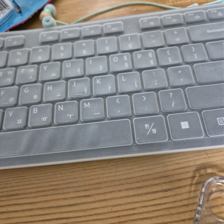

In [ ]:
## For debug
## 근데 이렇게 분해하는 것 말고, 직접 tensor를 분해해야되는거 아닌가
for t in img_all:
  print(t.shape)
  to_img = transforms.ToPILImage()
  img = to_img(t)

## Patch Embedding
- 이미지를 받았을때 Linear Projection으로 변경
- Positional Embedding까지 추가


In [62]:
# 예시 코드
# https://velog.io/@pre_f_86/PyTorch%EB%A1%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%8C%A8%EC%B9%98%EB%A1%9C-%EB%A7%8C%EB%93%A4%EA%B8%B0
b = 2
c = 3 # 채널의 수
p = 2 # 패치의 크기
h = 4 # 이미지의 높이
w = 4 # 이미지의 너비
img_test = torch.tensor(list(range(b*c*h*w)),dtype=torch.float32).reshape(b,c,h,w)+1 # 이미지를 c,h,w 형식으로 선언
img_test
# 내가 자른 텐서가 잘 잘렸는지 확인


tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]],

         [[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]],

         [[33., 34., 35., 36.],
          [37., 38., 39., 40.],
          [41., 42., 43., 44.],
          [45., 46., 47., 48.]]],


        [[[49., 50., 51., 52.],
          [53., 54., 55., 56.],
          [57., 58., 59., 60.],
          [61., 62., 63., 64.]],

         [[65., 66., 67., 68.],
          [69., 70., 71., 72.],
          [73., 74., 75., 76.],
          [77., 78., 79., 80.]],

         [[81., 82., 83., 84.],
          [85., 86., 87., 88.],
          [89., 90., 91., 92.],
          [93., 94., 95., 96.]]]])

Need to be
```
tensor([[[ 1.,  2.,  5.,  6.,  3.,  4.,  7.,  8.,  9., 10., 13., 14.],
         ... ])
```

In [65]:
n = w//p
patched_img = img_test.reshape(b,c,h//p,p,w//p,p) # 이미지 1개당 N*N개 패치가 나오고, 패치 하나의 이미지는 P*P*C
patched_img = patched_img.transpose(3,4)
patched_img = patched_img.transpose(1,3)
patched_img = patched_img.transpose(1,2)
patched_img = patched_img.reshape(b,n*n,p*p*c)
patched_img
# 이걸 Linear하게 변경을 한다면?

tensor([[[ 1.,  2.,  5.,  6., 17., 18., 21., 22., 33., 34., 37., 38.],
         [ 3.,  4.,  7.,  8., 19., 20., 23., 24., 35., 36., 39., 40.],
         [ 9., 10., 13., 14., 25., 26., 29., 30., 41., 42., 45., 46.],
         [11., 12., 15., 16., 27., 28., 31., 32., 43., 44., 47., 48.]],

        [[49., 50., 53., 54., 65., 66., 69., 70., 81., 82., 85., 86.],
         [51., 52., 55., 56., 67., 68., 71., 72., 83., 84., 87., 88.],
         [57., 58., 61., 62., 73., 74., 77., 78., 89., 90., 93., 94.],
         [59., 60., 63., 64., 75., 76., 79., 80., 91., 92., 95., 96.]]])

In [66]:
# 1. Patch Embedding
# 0. Patch Embedding Variables
p = 16 # patch
w = 224 # width
h = 224 # height
c = 3 # channel
b = 10 # batch

n = w//p
patched_img = img_all.view(b,c,h//p,p,w//p,p) # 이미지 1개당 N*N개 패치가 나오고, 패치 하나의 이미지는 P*P*C
patched_img = patched_img.transpose(3,4)
patched_img = patched_img.transpose(1,3)
patched_img = patched_img.transpose(1,2)
patched_img = patched_img.reshape(b,n*n,p*p*c)
patched_img.shape
## 이렇게 한다고 끝이 아닌듯함. 내가 원하는 대로 잘렸는지 확인이 필요함 (복원했을때 잘 보이게)
## nn.Conv2d로도 할 수 있는 듯함. 이걸로도 구현해보자

torch.Size([10, 196, 768])

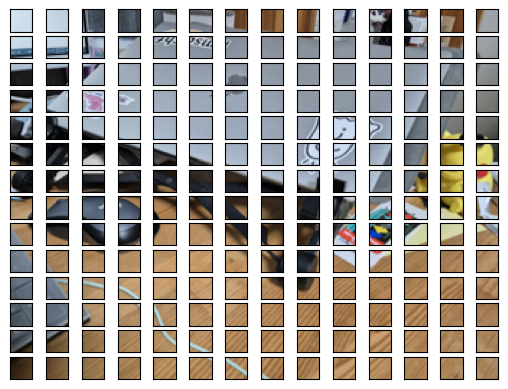

In [73]:
# Patch Debug
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
rows = n
cols = n
i = 1

for data in patched_img:
  for patch in data:
    tmp = patch.view(c,p,p)
    # print(tmp.shape)
    to_img = transforms.ToPILImage()
    img_back = to_img(tmp)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img_back)
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
  break
plt.show()

# Transformer 구조


In [ ]:
# Transformer

# Training